In [2]:
#export
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [4]:
#export
import pickle,gzip,math,torch,matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
from fastai import datasets

In [6]:
from pathlib import Path
from torch.nn import init

In [8]:
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/Users/abhinavverma/.fastai/data/mnist.pkl.gz')

In [9]:
#export
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))
def normalize(x,m,s):
    return (x-m)/s

In [10]:
x_train,y_train,x_valid,y_valid = get_data()

In [12]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [13]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [14]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.0001), tensor(1.))

In [15]:
#export
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [16]:
test_near_zero(train_mean)

In [17]:
test_near_zero(1-x_train.std())

In [18]:
??nn.Linear

We will use kaiming_uniform to initialize the weights as the mnist is a small example. so this is going with the defaults

In [159]:
#Global variables
n,m = x_train.shape
c = y_train.max().item()+1
nh = 50
n,m,c

(50000, 784, 10)

In [20]:
#model class is a callable class so it can be called like a function
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [26]:
#Model class
model = Model(m,nh,10)

In [24]:
model(x_train)

torch.Size([50000, 10])

In [27]:
#Global variables
pred = model(x_train)

##### We have already seen the importance of the softmax function. The softmax function is used to calculate the probabailities of a category in a multi-class class classification. 

In [25]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [28]:
softmax_pred = log_softmax(pred)

In [29]:
softmax_pred

tensor([[-2.8977, -2.2487, -2.8949,  ..., -2.2749, -1.8786, -2.6079],
        [-2.7164, -2.1471, -2.6864,  ..., -2.2885, -1.9710, -2.7302],
        [-2.5435, -2.4374, -2.8221,  ..., -2.5087, -2.1419, -2.0730],
        ...,
        [-2.3768, -2.5188, -2.7223,  ..., -2.3439, -2.0737, -2.3840],
        [-2.6748, -2.6027, -2.4636,  ..., -2.2222, -2.0227, -2.3758],
        [-2.5432, -2.6758, -2.2384,  ..., -2.2847, -2.0998, -2.5639]],
       grad_fn=<LogBackward>)

Now for cross entropy

In [30]:
def nll(pred,label):
    return -pred[range(label.shape[0]),label].mean()

In [32]:
nll(softmax_pred,y_train)

tensor(2.3521, grad_fn=<NegBackward>)

In [39]:
??torch.max

In [40]:
#this is calculated based on the log sum exp trick, a is the max value
def logsumexp(x):
    a = x.max(-1)[0]
    return a + (x-a[:,None]).exp().sum(-1).log()

In [41]:
#our log softmax
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [42]:
softmax_pred_exp = log_softmax(pred)

In [44]:
#test_near(nll(log_softmax(pred), y_train), loss)

In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.

In [45]:
test_near_zero(F.cross_entropy(pred, y_train)-nll(log_softmax(pred), y_train))

So the implementation is pretty accurate

In [117]:
#Global variable
loss_func = F.cross_entropy

In [46]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

We will use nn.Sequential to add layers to a Pytorch module.

In [47]:
#new Model
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [48]:
#export
from torch import optim

In [55]:
#Access lr or other parameters from optimizer.useful for modifying during learning
optim.SGD(model.parameters(), lr=0.5).param_groups[0]['lr']

0.5

In [60]:
#returns model and optimizer
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=0.5)

Since it is clunky to iterate through mini batches and specifying batch size all the time we will specify our dataset class and learn more about Pytorch Dataset,Dataloaders and RandomSamplers

In [124]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

DataLoaders are added to make the training loop much cleaner

In [57]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [97]:
model, _ = get_model()

In [87]:
next(model.named_children())

('0', Linear(in_features=784, out_features=50, bias=True))

In [96]:
#How to access the weights of every layer. Obviously there has to be an optimized way
#next(model[0].parameters())[0].data

In [100]:
#Change weights using apply method of Pytorch
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        
        m.weight.data.fill_(1.0)
        print(m.weight)
    
        
        
#model.apply(init_weights)

#### Random sampling
We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [101]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [125]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [103]:
small_ds = Dataset(*train_ds[:10])

In [104]:
small_ds

In [105]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [106]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([5, 6, 1]), tensor([3, 4, 7]), tensor([9, 2, 0]), tensor([8])]

In [107]:
#Dataloader with a custom Random sampleer
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

But we can also use Pytorch's built in method of data sampling. It's the same as normal dataloader and sampler we defined above but it has a num_workers which allows for parallel processing which will be necessary in the future hence we use them instead

In [126]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [127]:
#Global variable
bs=64

In [128]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [129]:
#fit before Callback
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [130]:
#Validation fit before callback
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [131]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [132]:
#get Dataloader and define model
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()


In [133]:
#fit
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2402) tensor(0.9323)
1 tensor(1.2160) tensor(0.7853)
2 tensor(0.2268) tensor(0.9414)
3 tensor(0.1805) tensor(0.9487)
4 tensor(0.1883) tensor(0.9498)


In [134]:
assert acc > 0.9

The train_dl and valid_dl can be combined together as it's better to combine things into a class than call it from a function. So the train_dl and valid_dl are combined into a databunch

In [135]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [141]:
a = zip(*get_dls(train_ds, valid_ds, bs))

In [148]:
get_dls(train_ds, valid_ds, bs)

(<torch.utils.data.dataloader.DataLoader at 0x1a246e13c8>,
 <torch.utils.data.dataloader.DataLoader at 0x1a25539c18>)

In [162]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c) #c = y_train.max()+1

Let's continue our class factorization by combining get_model function and loss_func and Databunch into a Learner class.

In [163]:
#export
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [165]:
data.c

10

In [164]:
learn = Learner(*get_model(data), loss_func, data)

In [166]:
#new fit
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [167]:
loss,acc = fit(4, learn)

0 tensor(0.4959) tensor(0.8421)
1 tensor(0.2965) tensor(0.9240)
2 tensor(0.2456) tensor(0.9360)
3 tensor(0.2628) tensor(0.9349)


In [168]:
"""
loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
"""
#This is one batch of training so we can combine it in a function one_batch and all callbacks at every step

'\nloss = learn.loss_func(learn.model(xb), yb)\n            loss.backward()\n            learn.opt.step()\n            learn.opt.zero_grad()\n'

In [169]:
def one_batch(xb,yb,cb):
    """
    loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
    The learner object is passed to the callback class. So it's accessed from the callback class
    We add callbacks before each and every step of the fit function
    cb.begin_batch - Called on batch begin
    cb.learn.loss_func The learn object is called from the loss function
    cb.learn.model(xb) - forward pass
    cb.after_backward() - after the backward pass
    cb.learn.opt.step() -optimizer called from the learner obj accessed from the callback object
    cb.after_step() after opt.zero_grad()
    """
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

In [170]:
def all_batches(dl,cb):
    """
    This function replaces the second for loop in the original fit function
    for xb,yb in learn.data.train_dl:
    cb.do_stop callback function for handling after the training loop is complete
    """
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

In [172]:
def fit(epochs, learn, cb):
    """
    cb.begin_fit -  on begin of fit function
    cb.begin_epoch -  on start of epoch
    cb.begin_validate - on validtion step begin
    cb.do_stop - called after epoch ends to stop training
    """
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

Callback is an abstract class. It acts like a class which has factory methods which are then implemented by the various callback classes. 

In [173]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

Callback handler class is used to take a list of the callbacks and implement them in the fit function. So many different callbacks can be implemented. Later we will add an order to it to initialize the order of the callback classes being executed

In [176]:
class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []
    
    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

In [177]:
class TestCallback(Callback):
    
    def begin_epoch(self,epoch):
        super().begin_epoch(epoch)
        print("Beginning epoch")
        print(self.learn.data.c)
        print(type(self.learn))
        return True
        
        
    
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.n_iters = 0
        print("iteration step begins")
        return True
        
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        print("Steps over")
        if self.n_iters>=10: self.learn.stop = True
        return True

In [178]:
fit(1, Learner(*get_model(data), loss_func, data), cb=CallbackHandler([TestCallback()]))

iteration step begins
Beginning epoch
10
<class '__main__.Learner'>
1
Steps over
2
Steps over
3
Steps over
4
Steps over
5
Steps over
6
Steps over
7
Steps over
8
Steps over
9
Steps over
10
Steps over


Let's see if we can make things simpler and more flexible, so that a single class has access to everything and can change anything at any time. One batch , all batches and the fit function all access the same variables and they are in different classes so the fact that we're passing cb to so many functions is a strong hint they should all be in the same class!

In [179]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [180]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

In [181]:
class Runner:
    """
    Contains the one_batch,all_batches and fit function
    """
    
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs
    
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False
    
    
    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False
        
    

In [182]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [184]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [207]:
learn = Learner(*get_model(data), loss_func, data)

In [208]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [210]:
stats.train_stats.in_train

True

In [217]:
stats.set_runner(Runner())
stats.run.n_iter = 0

In [215]:
run.fit(4, learn)

train: [0.560341796875, tensor(0.8370)]
valid: [0.419004833984375, tensor(0.8726)]
train: [0.27896775390625, tensor(0.9221)]
valid: [0.390334375, tensor(0.9049)]
train: [0.23098544921875, tensor(0.9352)]
valid: [0.20263787841796874, tensor(0.9451)]
train: [0.206239296875, tensor(0.9419)]
valid: [0.2068587646484375, tensor(0.9444)]


In [189]:
#export
from functools import partial

In [190]:
acc_cbf = partial(AvgStatsCallback,accuracy)

In [191]:
run = Runner(cb_funcs=acc_cbf)

In [192]:
run.fit(1, learn)

train: [0.1477126953125, tensor(0.9586)]
valid: [0.1758092041015625, tensor(0.9545)]


In [193]:
run.avg_stats.train_stats

train: [0.1477126953125, tensor(0.9586)]

In [220]:
??acc_cbf

## Annealing
Finally we move on to annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

In [221]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [223]:
tensor([0] + listify([0.3,0.7]))

tensor([0.0000, 0.3000, 0.7000])

In [228]:
torch.cumsum(tensor([0.0000, 0.3000, 0.7000]),0)

tensor([0.0000, 0.3000, 1.0000])

Reinitializing the databunch for annealing practice

In [229]:

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

create a learner class like the original fast.ai cnn_learner,collab_learner etc

In [230]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [231]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [232]:
%time run.fit(3, learn)

train: [0.423122578125, tensor(0.8762)]
valid: [0.686657568359375, tensor(0.8233)]
train: [0.2093975390625, tensor(0.9411)]
valid: [0.2036911865234375, tensor(0.9470)]
train: [0.17966875, tensor(0.9490)]
valid: [0.6572900390625, tensor(0.8650)]
CPU times: user 4.05 s, sys: 568 ms, total: 4.62 s
Wall time: 4.63 s


In [234]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

%time run.fit(3, learn)

train: [0.27696685546875, tensor(0.9146)]
valid: [0.355135107421875, tensor(0.9045)]
train: [0.129698564453125, tensor(0.9599)]
valid: [0.2441772705078125, tensor(0.9208)]
train: [0.101127255859375, tensor(0.9697)]
valid: [0.11380869140625, tensor(0.9666)]
CPU times: user 3.71 s, sys: 172 ms, total: 3.89 s
Wall time: 3.62 s


In [235]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [238]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

Annealer is a higher order function which we will use as a decorator . Use of a decorator is so that we have a function defined that has the start and end epochs defined. We can then play around with experimenting with the learning rate depending on the pos

In [239]:
f = sched_lin(1,2)
f(0.3)

1.3

In [240]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [241]:
a = torch.arange(0, 100)

In [243]:
a.shape[0]

100

In [244]:
#export
torch.Tensor.ndim = property(lambda x: len(x.shape))

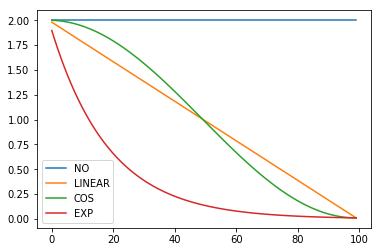

In [245]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

Obviously for a deep neural network, as has been proved by papers by Leslie Smith , it's not enough to have a simple annealer, you need to be able to combine different types of annealing to have an effect

In [246]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [247]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
#This returns a partial function which takes pos as an argument

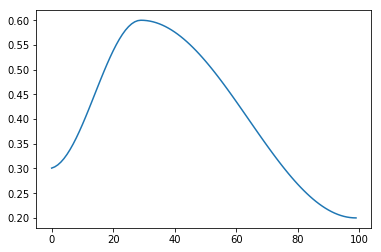

In [248]:
plt.plot(a, [sched(o) for o in p])

In [249]:
[sched(o) for o in p]

[0.300821712500613,
 0.30327785734525914,
 0.3073415244343397,
 0.312968176731064,
 0.32009617502771615,
 0.32864744467745965,
 0.33852828141619395,
 0.34963040189971495,
 0.3618321902634952,
 0.3749999924289653,
 0.3889894796160202,
 0.4036474263545824,
 0.41881322161814194,
 0.43432070577090537,
 0.4499999934432915,
 0.46567924562063967,
 0.481186748064359,
 0.49635256117381743,
 0.5110104920688123,
 0.5249999807287408,
 0.5381677557284723,
 0.5503695750666513,
 0.561471715791711,
 0.5713525318490361,
 0.5799038050045323,
 0.587031808843955,
 0.5926584646063182,
 0.5967221287750467,
 0.5991782799372168,
 0.5999999999999894,
 0.599798613928689,
 0.5991948597109517,
 0.5981899596291562,
 0.5967859267449199,
 0.5949855928702494,
 0.5927925836409279,
 0.5902113154892887,
 0.5872469867501008,
 0.5839055671918064,
 0.580193806683369,
 0.5761191407925101,
 0.5716897696446975,
 0.5669146604639578,
 0.561803435124498,
 0.5563663326657353,
 0.5506142975932043,
 0.5445590078051719,
 0.538212529

In [250]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [252]:
camel2snake('Recorder') # name of the Recorder object that will be used by run

'recorder'

In [253]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [254]:
%time run.fit(3,learn)

train: [0.3537401171875, tensor(0.8932)]
valid: [0.3076665771484375, tensor(0.9180)]
train: [0.200146640625, tensor(0.9441)]
valid: [0.19976873779296875, tensor(0.9453)]
train: [0.096998173828125, tensor(0.9702)]
valid: [0.10359298095703125, tensor(0.9705)]
CPU times: user 4.06 s, sys: 496 ms, total: 4.55 s
Wall time: 4.39 s


Accuracy upto 97%. Not bad

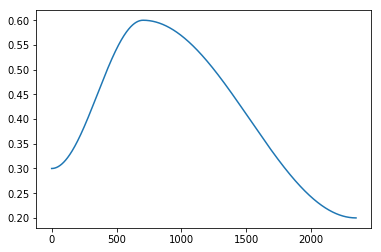

In [255]:
run.recorder.plot_lr() #learn.lr_find() in fast.ai v1